In [1]:
import numpy as np
from scipy.stats import rv_discrete
from numpy import genfromtxt
import matplotlib.pyplot as plt
from numpy import genfromtxt

In [2]:
#load the saved data for further use:
t_list = genfromtxt('pyrazine t_list.csv', delimiter=',', dtype=np.complex128)
auto_list = genfromtxt('pyrazine auto_list.csv', delimiter=',', dtype=np.complex128)

In [3]:
#time axis
timearray = np.array(t_list)*0.6582119  # hbar = 0.6582119 (eV fs)
dtime  = t_list[2]-t_list[1]

restime = len(timearray)
denergy  = 2 * np.pi / (restime * dtime)
energyaxis = np.concatenate((np.arange(0, restime/ 2-1),
                        np.arange(-restime/ 2, 0))) * denergy
ZeroPointEnergy = np.load('pyrazine zero point energy.npy')
energyaxisshifted = energyaxis - ZeroPointEnergy
energyaxisshifted_mask = (energyaxisshifted >= -1.1) & (energyaxisshifted <= 1.4)

autoarray = np.array(auto_list)
autoarray *= np.exp(-timearray/30) #broadening function
autofft  = np.fft.ifft(autoarray)
autofft *= 40 #adjustable scaling factor

In [4]:
def total_variation_distance(p, q):
    return 0.5 * np.sum(np.abs(p - q))

In [5]:
f_x = np.abs(np.real(autofft))-np.min(np.abs(np.real(autofft)))

f_x = f_x / np.sum(f_x)

target_distribution = rv_discrete(values=(energyaxisshifted, f_x))

np.random.seed(0) 
tvd_thresholds = [0.04, 0.03, 0.02, 0.01] 
max_measurements = 200000  

required_measurements = {tvd: None for tvd in tvd_thresholds}  
empirical_distributions = {tvd: [] for tvd in tvd_thresholds}
initial_measurements = {tvd: None for tvd in tvd_thresholds} 
initial_distributions = {tvd: None for tvd in tvd_thresholds}  
required_tvds = {tvd: None for tvd in tvd_thresholds}  


consecutive_threshold_met = 5  
sample_counts = []
tvds = []
stable_counts = {tvd: 0 for tvd in tvd_thresholds}  


for N in range(1000, max_measurements + 1, 1000):
    
    samples = target_distribution.rvs(size=N)
    
    
    empirical_counts = np.array([np.sum(samples == x) for x in energyaxisshifted])
    empirical_distribution = empirical_counts / N

    
    current_tvd = total_variation_distance(f_x[energyaxisshifted_mask], empirical_distribution[energyaxisshifted_mask])
    sample_counts.append(N)
    tvds.append(current_tvd)
    
    for tvd in tvd_thresholds:
        if current_tvd < tvd:
            stable_counts[tvd] += 1  
            
            if stable_counts[tvd] == 1:
                initial_measurements[tvd] = N
                initial_distributions[tvd] = empirical_distribution.copy()
            
            if stable_counts[tvd] == consecutive_threshold_met and required_measurements[tvd] is None:
                required_measurements[tvd] = initial_measurements[tvd]
                empirical_distributions[tvd] = initial_distributions[tvd]
                required_tvds[tvd] = current_tvd  
                print(f"Number of Measurements Reaching TVD Threshold of {tvd*100:.2f}%：{initial_measurements[tvd]}, Actual TVD：{current_tvd*100:.2f}%")
        else:
            stable_counts[tvd] = 0            

Number of Measurements Reaching TVD Threshold of 4.00%：7000, Actual TVD：3.39%
Number of Measurements Reaching TVD Threshold of 3.00%：15000, Actual TVD：2.65%
Number of Measurements Reaching TVD Threshold of 2.00%：32000, Actual TVD：1.94%
Number of Measurements Reaching TVD Threshold of 1.00%：134000, Actual TVD：0.94%


Text(0, 0.5, 'Total Variation Distance (TVD)')

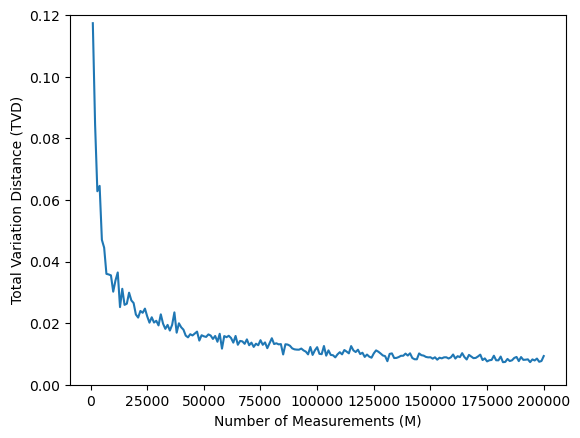

In [6]:
plt.plot(sample_counts, tvds)
plt.ylim(0, 0.12)
plt.xlabel("Number of Measurements (M)")
plt.ylabel("Total Variation Distance (TVD)")

Text(0.5, 0, 'Energy (eV)')

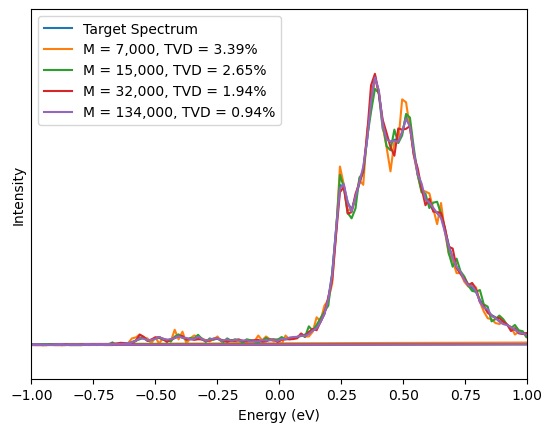

In [7]:
plt.plot(np.real(energyaxisshifted[energyaxisshifted_mask]), f_x[energyaxisshifted_mask], label='Target Spectrum')
for i, tvd in enumerate(tvd_thresholds):
    if empirical_distributions[tvd] is not None:
        plt.plot(np.real(energyaxisshifted[energyaxisshifted_mask]), empirical_distributions[tvd][energyaxisshifted_mask],label=f'M = {required_measurements[tvd]:,}, TVD = {required_tvds[tvd] * 100:.2f}%')

plt.ylim(-0.005,0.05)
plt.xlim(-1,1)
plt.yticks([])
plt.legend(loc='best')
plt.ylabel('Intensity')
plt.xlabel('Energy (eV)')